In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wherethereiscodethereisabug/sample_submission.csv
/kaggle/input/wherethereiscodethereisabug/train.csv
/kaggle/input/wherethereiscodethereisabug/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

In [3]:
train = pd.read_csv("../input/wherethereiscodethereisabug/train.csv")
test = pd.read_csv("../input/wherethereiscodethereisabug/test.csv")
sample = pd.read_csv("../input/wherethereiscodethereisabug/sample_submission.csv")

In [4]:
train.head()

,id,code,file_extension,label
0,8e7e71745d,a0 = alpha_winder(0)\n ...,py,0
1,f67fb60d2f,"[&](const ExprHandle& m, const ExprHandl...",cpp,0
2,9125d50679,self.play(\n pixels_to_dete...,py,0
3,e03dac0faa,"ksession.execute( new Message( ""help"" ...",java,1
4,ac09060d54,def test_is_fast(self):\n for token...,py,1


In [5]:
test.head()

,id,code,file_extension
0,3f11245f7c,])\n self.play(\n gr...,py
1,2892ddab29,\n @Override\n public Flowable<List<Play...,java
2,feadac64fa,"msg = (\n f""Can't l...",py
3,6317134d9e,import mock\nimport os\n\nimport pytest\n,py
4,f9a15d544e,tokenizer = AutoTokenizer.from_pretrai...,py


In [6]:
sample.head()

,id,label
0,3f11245f7c,0
1,2892ddab29,0
2,feadac64fa,0
3,6317134d9e,0
4,f9a15d544e,0


# Data Wrangling

In [7]:
train.shape

(232785, 4)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232785 entries, 0 to 232784
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              232785 non-null  object
 1   code            232785 non-null  object
 2   file_extension  232785 non-null  object
 3   label           232785 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 7.1+ MB


In [9]:
train.isnull().sum()

id                0
code              0
file_extension    0
label             0
dtype: int64

In [10]:
test.isnull().sum()

id                0
code              0
file_extension    0
dtype: int64

# Split

In [11]:
feats = ["code", "file_extension"]
X = train[feats]
y = train.label

# Instantiate Model

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                test_size = .2,
                                                    random_state = 0 
                                            )
model = make_pipeline(OneHotEncoder(handle_unknown = "ignore"), LogisticRegression())

# Fitting the Model

In [13]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

# Evaluation

In [14]:
print(classification_report(y_test, y_pred))
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.70      0.98      0.81     32117
           1       0.54      0.05      0.09     14440

    accuracy                           0.69     46557
   macro avg       0.62      0.51      0.45     46557
weighted avg       0.65      0.69      0.59     46557

Auc: 0.62


In [15]:

cv_result = cross_validate(model, X, y, cv = 5)
cv_result

{'fit_time': array([18.68571782, 14.34588861,  9.50796437,  9.66928291, 10.06934738]),
 'score_time': array([0.90345168, 0.59752226, 0.57828689, 0.84487391, 0.60604644]),
 'test_score': array([0.6892841 , 0.68883304, 0.69003587, 0.68833903, 0.68743691])}

In [16]:
scores = cv_result["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.689 +/- 0.001


<function matplotlib.pyplot.show(close=None, block=None)>

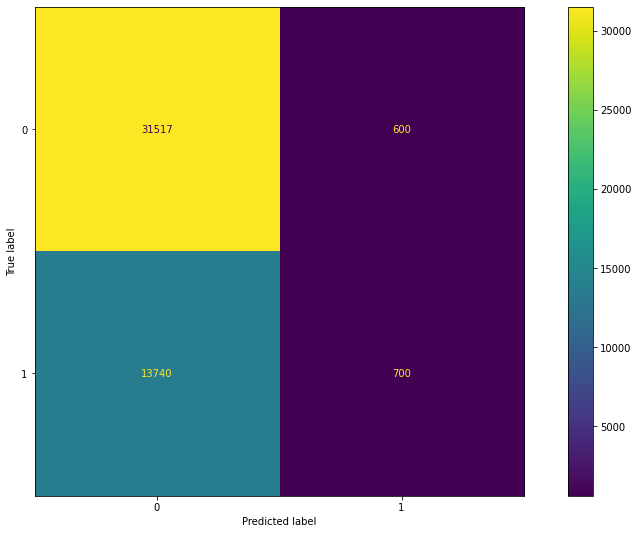

In [17]:
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
f, ax = plt.subplots(figsize=(16,9)
                    )
disp.plot(ax = ax)
plt.show

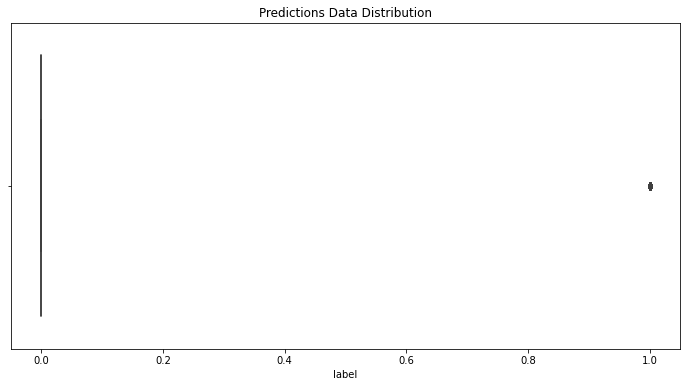

In [18]:
test = test[feats]
# Make prediction on the test set
predictions = model.predict(test)

# # Create a submission file
sub_file = sample.copy()
sub_file.label = predictions

# Check the distribution of your predictions
plt.figure(figsize=(12, 6))
sns.boxplot(sub_file.label)
plt.title('Predictions Data Distribution');

In [19]:
sub_file.head()

,id,label
0,3f11245f7c,0
1,2892ddab29,0
2,feadac64fa,0
3,6317134d9e,0
4,f9a15d544e,0


In [20]:
# sub_file.to_csv("bug.csv", index = False)

# Trying other Models
* Random Forests
* SVM
* Neural networks (CNN)

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = make_pipeline(OneHotEncoder(handle_unknown = "ignore"), RandomForestClassifier(max_depth = 3, random_state = 0))
clf.fit(X_train, y_train)
# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy score: 0.6919904633030479


              precision    recall  f1-score   support

           0       0.70      0.98      0.81     32117
           1       0.54      0.05      0.09     14440

    accuracy                           0.69     46557
   macro avg       0.62      0.51      0.45     46557
weighted avg       0.65      0.69      0.59     46557

Auc: 0.62


In [22]:
test = test[feats]
# Make prediction on the test set
predictions = clf.predict(test)

# # Create a submission file
sub_file = sample.copy()
sub_file.label = predictions

In [23]:
sub_file.head()

,id,label
0,3f11245f7c,0
1,2892ddab29,0
2,feadac64fa,0
3,6317134d9e,0
4,f9a15d544e,0


In [24]:
# sub_file.to_csv("bug1.csv", index = False)